# Connecting structures together

This example shows how to connect neurons in different structures together and is useful when you do not have the long range axons available. It can also be used within a volume, but note that this will then be in addition to what synapses touch detection provides (so useful when no axon is available).

* Define two volumes, ```VolumeA``` and ```VolumeB``` (far apart).
* Fill the volumes with ```dSPN``` and ```iSPN``` neurons respectively.
* Define the connection rule between the two neuron types.
* Create connections

In [1]:
import os
from snudda.create_cube_mesh import create_cube_mesh

network_path = os.path.join("networks", "connect_structures_network")
mesh_file_a = os.path.join(network_path, "mesh", "volume_A.obj")
mesh_file_b = os.path.join(network_path, "mesh", "volume_B.obj")

create_cube_mesh(mesh_file_a, [5e-3,0,0], 300e-6, "Volume A - connect structures example")
create_cube_mesh(mesh_file_b, [-5e-3,0,0], 300e-6, "Volume B - connect structures example")

In [2]:
from snudda.init import SnuddaInit

cnc = SnuddaInit(network_path=network_path, random_seed=123)

cnc.define_structure(struct_name="VolumeA", struct_mesh=mesh_file_a, d_min=15e-6, mesh_bin_width=50e-6)
cnc.define_structure(struct_name="VolumeB", struct_mesh=mesh_file_b, d_min=15e-6, mesh_bin_width=50e-6)

cnc.add_neurons(name="dSPN", num_neurons=20, volume_id="VolumeA",
                neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
cnc.add_neurons(name="iSPN", num_neurons=20, volume_id="VolumeB",
                neuron_dir=os.path.join("$DATA","neurons","striatum","ispn"))

# Normally we would use add_neuron_target to connect the neurons in the same volume together, 
# but this time we want to use connect_neurons instead.

proj_file = os.path.join("data", "ExampleProjection.json")

cnc.neuron_projection(neuron_name="dSPN", 
                      target_name="iSPN",
                      projection_name="ExampleProjection",
                      projection_file=proj_file,
                      source_volume="VolumeA",
                      dest_volume="VolumeB",
                      projection_radius=100e-6,
                      number_of_targets=[10, 5],
                      number_of_synapses=[10, 5],
                      dendrite_synapse_density="1",
                      connection_type="GABA",
                      dist_pruning=None,
                      f1=0.9,
                      soft_max=None,
                      mu2=None,
                      a3=None)


cnc.write_json()



Adding neurons: dSPN from dir $DATA/neurons/striatum/dspn
Adding neurons: iSPN from dir $DATA/neurons/striatum/ispn
Writing networks/connect_structures_network/network-config.json


In [3]:
from snudda.place import SnuddaPlace
sp = SnuddaPlace(network_path=network_path, verbose=False)
sp.parse_config()
sp.write_data()

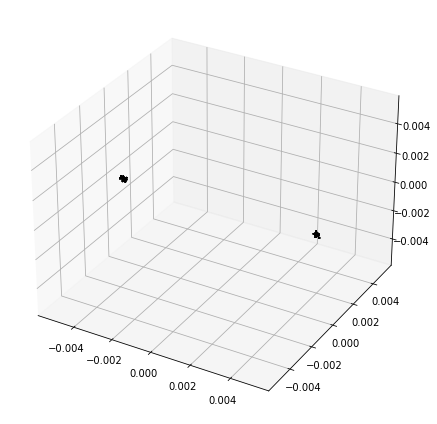

In [4]:
from snudda.plotting.plot_network import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

In [5]:
# TODO: Update logic so that if there are no connections allowed between the neurons present in a hyper voxel, then it goes faster

In [6]:
from snudda.detect import SnuddaDetect

sd = SnuddaDetect(network_path=network_path)
sd.detect()

No d_view specified, running distribute neurons in serial
Processing hyper voxel : 686/740 (20 neurons)
Processing hyper voxel : 26/740 (20 neurons)
Processing hyper voxel : 687/740 (18 neurons)
Processing hyper voxel : 6/740 (17 neurons)
Processing hyper voxel : 681/740 (16 neurons)
Processing hyper voxel : 27/740 (16 neurons)
Processing hyper voxel : 31/740 (15 neurons)
Processing hyper voxel : 667/740 (13 neurons)
Processing hyper voxel : 666/740 (13 neurons)
Processing hyper voxel : 682/740 (12 neurons)
Processing hyper voxel : 7/740 (12 neurons)
Processing hyper voxel : 706/740 (12 neurons)
Processing hyper voxel : 25/740 (11 neurons)
Processing hyper voxel : 32/740 (10 neurons)
Processing hyper voxel : 701/740 (9 neurons)
Processing hyper voxel : 21/740 (9 neurons)
Processing hyper voxel : 11/740 (9 neurons)
Processing hyper voxel : 691/740 (9 neurons)
Processing hyper voxel : 46/740 (8 neurons)
Processing hyper voxel : 685/740 (8 neurons)
Processing hyper voxel : 5/740 (8 neuron

In [7]:
from snudda.project import SnuddaProject

sp = SnuddaProject(network_path=network_path)
sp.project()
sp.write()

pre dSPN, post iSPN


In [8]:
from snudda.prune import SnuddaPrune

sp = SnuddaPrune(network_path=network_path)
sp.prune()


Synapses before pruning: 433
Synapses after pruning: 381 (87.99 % kept)
No gap junctions to prune.
